In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz

import rdata

## What Motivates Sharing? 

Analysing social networks using multilevel modeling tools

data(KosterLeckie)

Year of food transfers among 25 households in Arang Dak

25!/(2!(25-2)!) = 300 dyads

2871 observed transfers between households 

How much sharing explained by reciprocity?

How much generalized giving? 

In [9]:
parsed = rdata.parser.parse_file('Data/KosterLeckie.rda')
converted = rdata.conversion.convert(parsed)

In [13]:
converted.keys()

dict_keys(['kl_dyads', 'kl_households'])

In [14]:
koster_dyads = converted['kl_dyads']
koster_households = converted['kl_households']

In [19]:
koster_households

,hid,hgame,hfish,hpigs,hwealth,hpastor
1,1,0.05,0.06,0.00,14.162,0
2,2,0.25,0.17,1.75,27.405,0
3,3,2.29,0.66,5.75,9.900,0
4,4,0.04,0.43,1.50,7.267,0
5,5,0.07,0.12,1.25,9.982,0
6,6,0.03,0.20,2.50,16.186,0
7,7,0.27,0.74,3.00,8.068,0
8,8,0.04,0.16,2.00,17.437,0
9,9,0.39,0.30,5.75,16.931,0
10,10,6.09,0.04,0.00,17.421,0


In [17]:
koster_dyads

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
1,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
2,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
3,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
4,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
5,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,22,24,296,0,1,0.000,0,0,1,0,-2.442,0.000,0
297,22,25,297,2,0,-0.637,0,0,0,1,-1.747,0.026,0
298,23,24,298,2,0,-0.092,0,0,0,0,-1.798,0.000,0
299,23,25,299,4,0,-0.818,0,0,1,0,-1.848,0.031,0


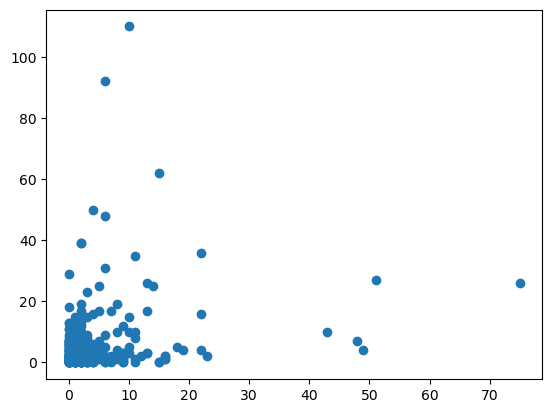

In [25]:
plt.scatter(x=koster_dyads['giftsAB'],y=koster_dyads['giftsBA'])

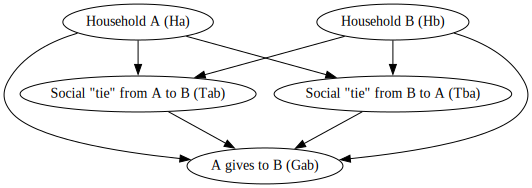

In [496]:
g = graphviz.Digraph('g')

g.edge('Household A (Ha)','A gives to B (Gab)')
g.edge('Household B (Hb)','A gives to B (Gab)')
g.edge('Household A (Ha)', 'Social "tie" from A to B (Tab)')
g.edge('Household B (Hb)', 'Social "tie" from A to B (Tab)')
g.edge('Social "tie" from A to B (Tab)','A gives to B (Gab)')
g.edge('Household A (Ha)','Social "tie" from B to A (Tba)')
g.edge('Social "tie" from B to A (Tba)','A gives to B (Gab)')
g.edge('Household B (Hb)','Social "tie" from B to A (Tba)')
g

Potential features:

Location of A/B

Wealth of A/B

Kinship

Friendship

Tab and Tba are not observable

Social network: Pattern of directed exchange

Social networks are abstractions, are not data

What is a principled approach? 

We must resist adhockery, should have a method thats built on a generative model about the process we are trying to understand



## Drawing the Social Owl

1) Estimand: Reciprocity & what explains it

2) Generative model

3) Statistical model

4) Analyze the sample

In [310]:
N = 25 #25 households

dyads = []
for i in range(N):
    for j in range(i+1,N):
        dyads.append([i,j])
dyads = np.array(dyads)

# Simulate "friendships" in which ties are shared
f = np.random.binomial(1,0.1,size=dyads.shape[0]) # 10% of dyads are friends

# Now simulate directed ties for all individuals 
# there can be ties that are not reciprocal

alpha = -3
y = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i != j:
            dyadidx = sorted([i,j])
            mask = (dyads[:, 0] == dyadidx[0]) & (dyads[:, 1] == dyadidx[1])
            the_dyad = np.where(mask)[0]
            p_tie = f[the_dyad] + (1-f[the_dyad])*expit(alpha) #If they are friends they have a tie, if they're not freinds they have the base rate alpha
            y[i,j] = np.random.binomial(1,p_tie)

In [313]:
# Simulate gifts
giftsAB = np.zeros(len(dyads))
giftsBA = np.zeros(len(dyads))
lam = np.log([0.5,2])

for i in range(len(dyads)):
    A, B = dyads[i]
    giftsAB[i] = np.random.poisson(lam=np.exp(lam[int(y[A,B])]),size=1)
    giftsBA[i] = np.random.poisson(lam=np.exp(lam[int(y[B,A])]),size=1)

Gifts A to B

Gab ~ Poisson(lamAB)

log(lamAB) = alpha + TAB

alpha: average

TAB: Tie A to B

Symmetric for B to A

Want to study the covariance in ties. This is a resarch question. 

Partial pooling for networks ties. This is helpful here as there is varying amounts of behaviour within individuals and in certain ties 

In [322]:
n_dyads = np.arange(len(dyads))

In [343]:
# dyad model
with pm.Model() as mGD:
    # Dyad effects
    sd_dist = pm.Exponential.dist(1,shape=2)
    chol,corr, sigmas   = pm.LKJCholeskyCov('Rho', eta = 4, n=2,sd_dist=sd_dist)
    
    z    = pm.Normal('z',0,1,shape=(len(dyads),2)) #vals_raw in pymc docs
    v    = pm.Deterministic('v', pt.dot(chol,z.T).T) #vals in pymc docs, T in lecture

    # Dyad model
    a = pm.Normal('a',3)
    lambdaAB = pm.Deterministic('lambdaAB',pm.math.exp(a + v[n_dyads,0]))
    lambdaBA = pm.Deterministic('lambdaBA',pm.math.exp(a + v[n_dyads,1]))
    
    GAB = pm.Poisson('GAB',lambdaAB, observed=giftsAB)
    GBA = pm.Poisson('GBA',lambdaBA, observed=giftsBA)
    
    mGD_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, z, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [344]:
az.summary(mGD_trace,var_names=['v'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"v[0, 0]",-0.332,0.619,-1.536,0.769,0.007,0.009,7177.0,3028.0,1.0
"v[0, 1]",-0.303,0.581,-1.378,0.816,0.007,0.008,7165.0,2993.0,1.0
"v[1, 0]",-0.337,0.639,-1.567,0.864,0.007,0.010,8557.0,2706.0,1.0
"v[1, 1]",-0.302,0.585,-1.407,0.782,0.008,0.010,5805.0,2370.0,1.0
"v[2, 0]",-0.073,0.606,-1.221,1.064,0.007,0.011,7073.0,3014.0,1.0
...,...,...,...,...,...,...,...,...,...
"v[297, 1]",0.160,0.538,-0.903,1.106,0.006,0.009,7669.0,3082.0,1.0
"v[298, 0]",-0.337,0.656,-1.637,0.827,0.007,0.010,8918.0,2543.0,1.0
"v[298, 1]",-0.310,0.606,-1.476,0.784,0.007,0.009,6723.0,2877.0,1.0
"v[299, 0]",0.173,0.592,-0.886,1.287,0.007,0.009,7500.0,2454.0,1.0


In [359]:
T_est = mGD_trace.posterior.v.mean(dim=['chain','draw'])

Text(0.5, 0, 'Correlation within dyads')

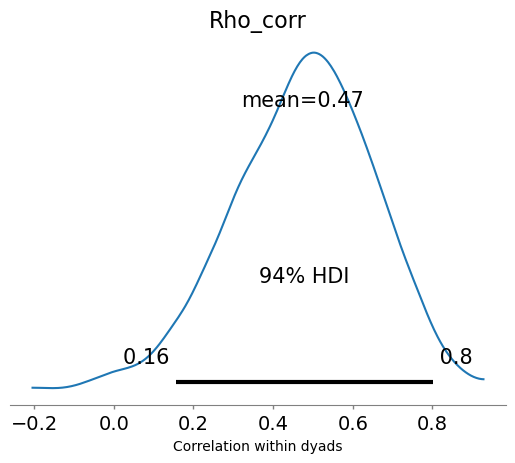

In [353]:
az.plot_posterior(mGD_trace.posterior.Rho_corr[:,:,0,1], )
plt.xlabel('Correlation within dyads')

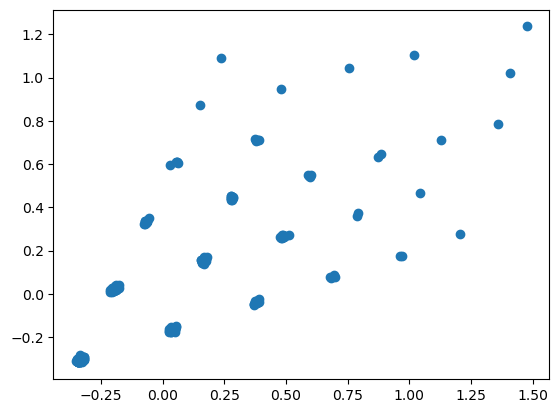

In [363]:
plt.scatter(T_est[:,0],T_est[:,1])

In [374]:
koster_dyads.hidB.max()

25

In [382]:
# dyad model
with pm.Model() as mGDkl:
    N_dyads = pm.MutableData('N_dyads',len(koster_dyads))
    N_households = pm.MutableData('N_households',koster_dyads['hidB'].max())
    D = pm.MutableData('D', np.arange(len(koster_dyads)))
    HA = pm.MutableData('HA',koster_dyads['hidA'].values)
    HB = pm.MutableData('HB',koster_dyads['hidB'].values)
    giftsAB = pm.MutableData('giftsAB',koster_dyads['giftsAB'].values)
    giftsBA = pm.MutableData('giftsBA',koster_dyads['giftsBA'].values)
                       
                       
    # Dyad effects
    sd_dist = pm.Exponential.dist(1)
    chol,corr, sigmas   = pm.LKJCholeskyCov('Rho', eta = 4, n=2,sd_dist=sd_dist)
    
    z    = pm.Normal('z',0,1,shape=(N_dyads,2)) #vals_raw in pymc docs
    v    = pm.Deterministic('v', pt.dot(chol,z.T).T) #vals in pymc docs, T in lecture

    # Dyad model
    a = pm.Normal('a',3)
    lambdaAB = pm.Deterministic('lambdaAB',pm.math.exp(a + v[D,0]))
    lambdaBA = pm.Deterministic('lambdaBA',pm.math.exp(a + v[D,1]))
    
    GAB = pm.Poisson('GAB',lambdaAB, observed=giftsAB)
    GBA = pm.Poisson('GBA',lambdaBA, observed=giftsBA)
    
    mGDkl_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, z, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [383]:
az.summary(mGDkl_trace,var_names=['a','Rho_corr','Rho_stds',])

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.565,0.083,0.405,0.716,0.002,0.001,1569.0,2294.0,1.00
"Rho_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"Rho_corr[0, 1]",0.347,0.070,0.216,0.474,0.003,0.002,678.0,1334.0,1.00
"Rho_corr[1, 0]",0.347,0.070,0.216,0.474,0.003,0.002,678.0,1334.0,1.00
"Rho_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4150.0,3871.0,1.00
Rho_stds[0],1.393,0.088,1.232,1.555,0.003,0.002,863.0,1286.0,1.01
Rho_stds[1],1.485,0.086,1.322,1.645,0.003,0.002,806.0,1375.0,1.00


Text(0.5, 0, 'Correlation within dyads')

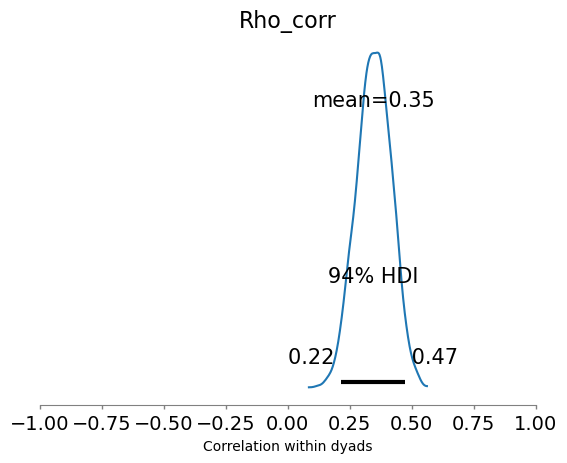

In [391]:
az.plot_posterior(mGDkl_trace.posterior.Rho_corr[:,:,0,1])
plt.xlim(-1,1)
plt.xlabel('Correlation within dyads')

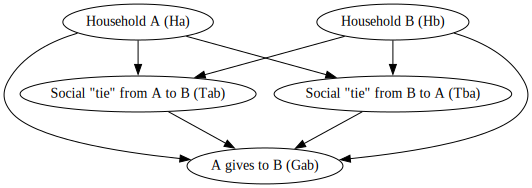

In [392]:
g

Need to deal with general household traits now (HA and HB). We know about these households because data was collected about them by an anthropologist. 

## Adding wealth to the generative sim, and the model

In [455]:
N = 25 #25 households

dyads = []
for i in range(N):
    for j in range(i+1,N):
        dyads.append([i,j])
dyads = np.array(dyads)
D_list = np.arange(len(dyads))
# Simulate "friendships" in which ties are shared
f = np.random.binomial(1,0.1,size=dyads.shape[0]) # 10% of dyads are friends

# Now simulate directed ties for all individuals 
# there can be ties that are not reciprocal

alpha = -3 # base rate of ties; -3 ~= 0.05
y = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i != j:
            dyadidx = sorted([i,j])
            mask = (dyads[:, 0] == dyadidx[0]) & (dyads[:, 1] == dyadidx[1])
            the_dyad = np.where(mask)[0]
            p_tie = f[the_dyad] + (1-f[the_dyad])*expit(alpha) #If they are friends they have a tie, if they're not freinds they have the base rate alpha
            y[i,j] = np.random.binomial(1,p_tie)

In [456]:
# simulate wealth
W = np.random.normal(0,1,size=N) # Standardized relative wealth in community
bWG = 0.5 # Effect of wealth on giving - rich give more
bWR = -1  # Effect of wealth on receiving - rich get less/ poor get more

# Simulate gifts
giftsAB_sim = np.zeros(len(dyads))
giftsBA_sim = np.zeros(len(dyads))
lam = np.log([0.5,2])

for i in range(len(dyads)):
    A, B = dyads[i]
    giftsAB_sim[i] = np.random.poisson(lam=np.exp(lam[int(y[A,B])] + bWG*W[A] + bWR*W[B]),size=1)
    giftsBA_sim[i] = np.random.poisson(lam=np.exp(lam[int(y[B,A])] + bWG*W[B] + bWR*W[A]),size=1)

This model is a varying effect clustered on household, not dyad. The household will have a giving and receiving MVnormal, with full covariance matrix.

25 households

300 dyads

600 counts/ 2871 transfers

602 social network parameters

53 household parameters

In [476]:
# General model
with pm.Model() as mGDGR:
    N_dyads = pm.MutableData('N_dyads',len(dyads))
    N_households = pm.MutableData('N_households',N)
    D = pm.MutableData('D', D_list)
    HA = pm.MutableData('HA',dyads[:,0])
    HB = pm.MutableData('HB',dyads[:,1])
    GAB = pm.MutableData('GAB',giftsAB_sim)
    GBA = pm.MutableData('GBA',giftsBA_sim)
    
    ## gr matrix of varying effects -non-centred
    sd_dist_gr = pm.Exponential.dist(1)
    chol_gr,corr_gr, sigmas_gr = pm.LKJCholeskyCov('Rho_gr',eta=2,n=2,sd_dist=sd_dist_gr)
    
    zgr = pm.Normal('zgr',0,1,shape=(N_dyads,2))
    gr  = pm.Deterministic('gr',pt.dot(chol_gr,zgr.T).T)
    
    # Dyad effects - non-centred
    sd_dist_T = pm.Exponential.dist(1,shape=2)
    chol_T,corr_T, sigmas_T   = pm.LKJCholeskyCov('Rho_T', eta = 2, n=2,sd_dist=sd_dist_T)
    
    zT    = pm.Normal('zT',0,1,shape=(N_dyads,2)) #vals_raw in pymc docs
    T    = pm.Deterministic('T', pt.dot(chol_T,zT.T).T) #vals in pymc docs, T in lecture

    # Dyad model
    a = pm.Normal('a',0,1)
    
    lambdaAB = pm.Deterministic('lambdaAB',pm.math.exp(a + T[D,0] + gr[HA,0] + gr[HB,1]))
    lambdaBA = pm.Deterministic('lambdaBA',pm.math.exp(a + T[D,1] + gr[HB,0] + gr[HA,1]))
    
    GAB_obs = pm.Poisson('GAB_obs',lambdaAB, observed=GAB)
    GBA_obs = pm.Poisson('GBA_obs',lambdaBA, observed=GBA)
    
    mGDGR_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho_gr, zgr, Rho_T, zT, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.


In [477]:
az.summary(mGDGR_trace,var_names =['~lambdaAB','~lambdaBA','~T','~zgr','~zT','~gr'])

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.727,0.162,-1.044,-0.439,0.004,0.003,1370.0,2081.0,1.00
Rho_gr[0],0.516,0.099,0.346,0.713,0.003,0.002,1113.0,2353.0,1.00
Rho_gr[1],-0.942,0.189,-1.298,-0.600,0.006,0.004,1054.0,1801.0,1.00
Rho_gr[2],0.528,0.175,0.185,0.834,0.006,0.004,975.0,1361.0,1.00
Rho_T[0],0.735,0.100,0.545,0.918,0.003,0.002,1466.0,2187.0,1.00
Rho_T[1],0.207,0.160,-0.087,0.508,0.008,0.006,375.0,642.0,1.01
Rho_T[2],0.523,0.107,0.316,0.722,0.005,0.003,522.0,647.0,1.01
"Rho_gr_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"Rho_gr_corr[0, 1]",-0.857,0.090,-0.994,-0.694,0.003,0.002,922.0,1436.0,1.00
"Rho_gr_corr[1, 0]",-0.857,0.090,-0.994,-0.694,0.003,0.002,922.0,1436.0,1.00


Text(0.5, 0, 'Correlation giving-receiving')

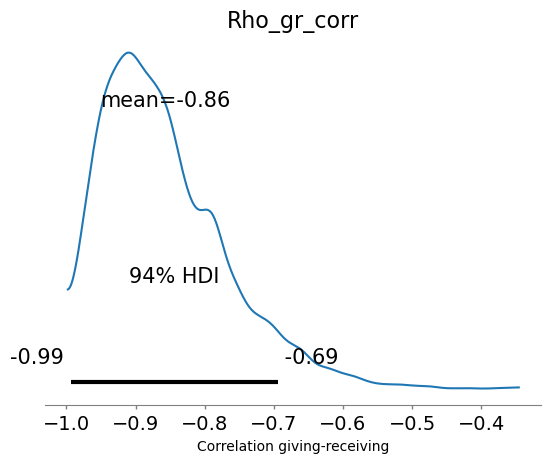

In [478]:
az.plot_posterior(mGDGR_trace.posterior.Rho_gr_corr[:,:,0,1])
plt.xlabel('Correlation giving-receiving')
#Should be a negative correlation, because in our sim richer houses give more
# and receive less. 

Text(0, 0.5, 'generalized receiving')

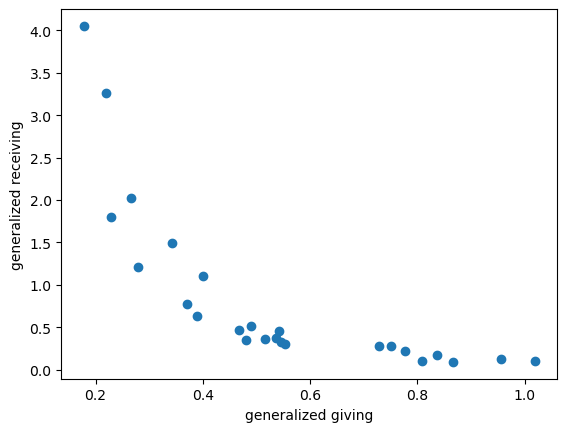

In [479]:
giving = (mGDGR_trace.posterior.a + mGDGR_trace.posterior.gr[:,:,:25,0]).mean(dim=['chain','draw'])
receiving = (mGDGR_trace.posterior.a + mGDGR_trace.posterior.gr[:,:,:25,1]).mean(dim=['chain','draw'])
plt.scatter(y = np.exp(receiving), 
            x = np.exp(giving))
plt.xlabel('generalized giving')
plt.ylabel('generalized receiving')

In [480]:
mGDGR_trace.posterior

<xarray.Dataset>
Dimensions:            (chain: 4, draw: 1000, zgr_dim_0: 300, zgr_dim_1: 2,
                        zT_dim_0: 300, zT_dim_1: 2, Rho_gr_dim_0: 3,
                        Rho_T_dim_0: 3, Rho_gr_corr_dim_0: 2,
                        Rho_gr_corr_dim_1: 2, Rho_gr_stds_dim_0: 2,
                        gr_dim_0: 300, gr_dim_1: 2, Rho_T_corr_dim_0: 2,
                        Rho_T_corr_dim_1: 2, Rho_T_stds_dim_0: 2, T_dim_0: 300,
                        T_dim_1: 2, lambdaAB_dim_0: 300, lambdaBA_dim_0: 300)
Coordinates: (12/20)
  * chain              (chain) int32 0 1 2 3
  * draw               (draw) int32 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * zgr_dim_0          (zgr_dim_0) int32 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * zgr_dim_1          (zgr_dim_1) int32 0 1
  * zT_dim_0           (zT_dim_0) int32 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * zT_dim_1           (zT_dim_1) int32 0 1
    ...                 ...
  * Rho_T_corr_dim_1   (Rho_T_corr_dim_1) int32 0 1
  * Rho_T_stds_dim_0   (Rho_T_stds_dim_0) int32 0 1
  * T_dim_0            (T_dim_0) int32 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * T_dim_1            (T_dim_1) int32 0 1
  * lambdaAB_dim_0     (lambdaAB_dim_0) int32 0 1 2 3 4 ... 295 296 297 298 299
  * lambdaBA_dim_0     (lambdaBA_dim_0) int32 0 1 2 3 4 ... 295 296 297 298 299
Data variables: (12/13)
    zgr                (chain, draw, zgr_dim_0, zgr_dim_1) float64 -0.8446 .....
    zT                 (chain, draw, zT_dim_0, zT_dim_1) float64 1.679 ... -0...
    a                  (chain, draw) float64 -0.6585 -0.5972 ... -0.569 -0.6032
    Rho_gr             (chain, draw, Rho_gr_dim_0) float64 0.5783 ... 0.7451
    Rho_T              (chain, draw, Rho_T_dim_0) float64 0.765 ... 0.4813
    Rho_gr_corr        (chain, draw, Rho_gr_corr_dim_0, Rho_gr_corr_dim_1) float64 ...
    ...                 ...
    gr                 (chain, draw, gr_dim_0, gr_dim_1) float64 -0.4885 ... ...
    Rho_T_corr         (chain, draw, Rho_T_corr_dim_0, Rho_T_corr_dim_1) float64 ...
    Rho_T_stds         (chain, draw, Rho_T_stds_dim_0) float64 0.765 ... 0.5969
    T                  (chain, draw, T_dim_0, T_dim_1) float64 1.284 ... 0.3885
    lambdaAB           (chain, draw, lambdaAB_dim_0) float64 0.8568 ... 0.2163
    lambdaBA           (chain, draw, lambdaBA_dim_0) float64 11.81 ... 1.958
Attributes:
    created_at:                 2023-03-01T17:18:43.290520
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1
    sampling_time:              85.79561734199524
    tuning_steps:               1000

<AxesSubplot: title={'center': 'Rho_T_corr'}>

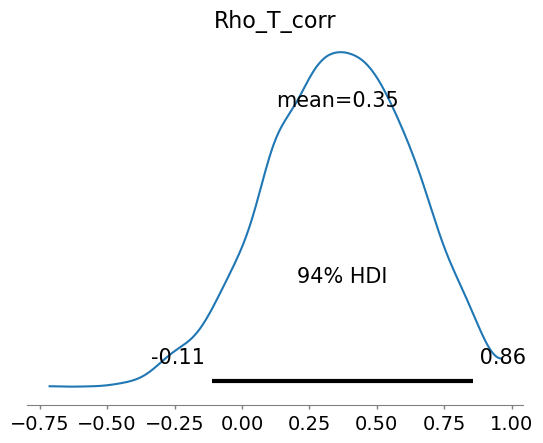

In [481]:
az.plot_posterior(mGDGR_trace.posterior.Rho_T_corr[:,:,0,1])

In [483]:
# General model, using real data 
with pm.Model() as mGDGR_real:
    
    N_dyads = pm.MutableData('N_dyads',len(koster_dyads))
    N_households = pm.MutableData('N_households',koster_dyads['hidB'].max())
    D = pm.MutableData('D', np.arange(len(koster_dyads)))
    HA = pm.MutableData('HA',koster_dyads['hidA'].values)
    HB = pm.MutableData('HB',koster_dyads['hidB'].values)
    GAB = pm.MutableData('GAB',koster_dyads['giftsAB'].values)
    GBA = pm.MutableData('GBA',koster_dyads['giftsBA'].values)
    
    ## gr matrix of varying effects -non-centred
    sd_dist_gr = pm.Exponential.dist(1)
    chol_gr,corr_gr, sigmas_gr = pm.LKJCholeskyCov('Rho_gr',eta=2,n=2,sd_dist=sd_dist_gr)
    
    zgr = pm.Normal('zgr',0,1,shape=(N_dyads,2))
    gr  = pm.Deterministic('gr',pt.dot(chol_gr,zgr.T).T)
    
    # Dyad effects - non-centred
    sd_dist_T = pm.Exponential.dist(1,shape=2)
    chol_T,corr_T, sigmas_T   = pm.LKJCholeskyCov('Rho_T', eta = 2, n=2,sd_dist=sd_dist_T)
    
    zT    = pm.Normal('zT',0,1,shape=(N_dyads,2)) #vals_raw in pymc docs
    T    = pm.Deterministic('T', pt.dot(chol_T,zT.T).T) #vals in pymc docs, T in lecture

    # Dyad model
    a = pm.Normal('a',0,1)
    
    lambdaAB = pm.Deterministic('lambdaAB',pm.math.exp(a + T[D,0] + gr[HA,0] + gr[HB,1]))
    lambdaBA = pm.Deterministic('lambdaBA',pm.math.exp(a + T[D,1] + gr[HB,0] + gr[HA,1]))
    
    GAB_obs = pm.Poisson('GAB_obs',lambdaAB, observed=GAB)
    GBA_obs = pm.Poisson('GBA_obs',lambdaBA, observed=GBA)
    
    mGDGR_real_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho_gr, zgr, Rho_T, zT, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


Text(0.5, 0, 'Correlation giving-receiving')

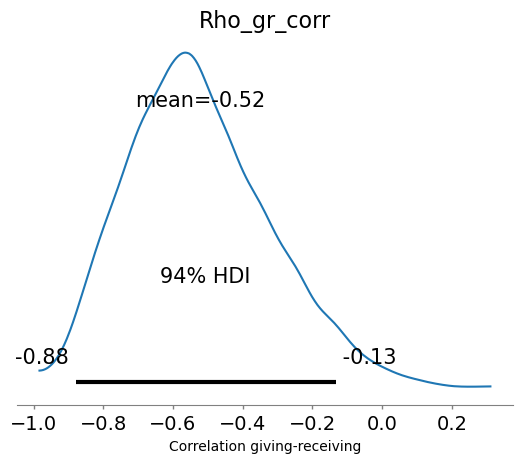

In [485]:
az.plot_posterior(mGDGR_real_trace.posterior.Rho_gr_corr[:,:,0,1])
plt.xlabel('Correlation giving-receiving')

Text(0.5, 0, 'Correlation within dyads)')

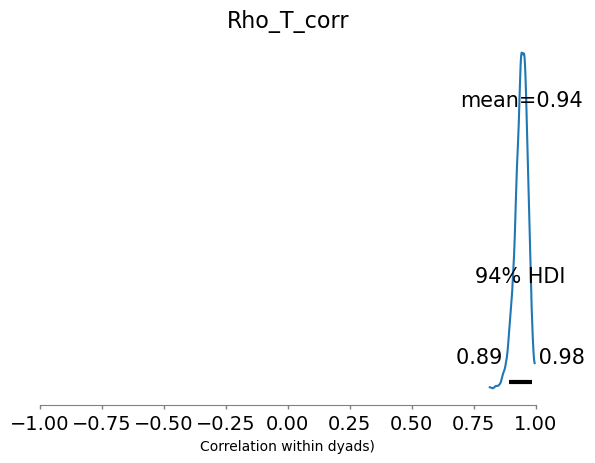

In [487]:
az.plot_posterior(mGDGR_real_trace.posterior.Rho_T_corr[:,:,0,1])
plt.xlim((-1,1))
plt.xlabel('Correlation within dyads)')
#Maximumm reciprocity, having netted out generalized giving and receiving

(0.0, 6.0)

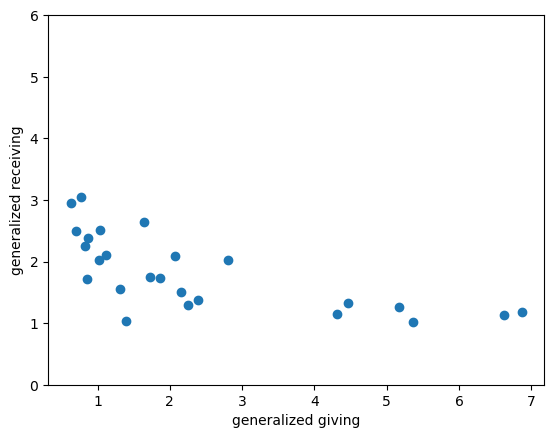

In [489]:
giving = (mGDGR_real_trace.posterior.a + mGDGR_real_trace.posterior.gr[:,:,:25,0]).mean(dim=['chain','draw'])
receiving = (mGDGR_real_trace.posterior.a + mGDGR_real_trace.posterior.gr[:,:,:25,1]).mean(dim=['chain','draw'])
plt.scatter(y = np.exp(receiving), 
            x = np.exp(giving))
plt.xlabel('generalized giving')
plt.ylabel('generalized receiving')
plt.ylim(0,6)

In [490]:
 ## Don't know a way to make those cool network graphs. 

## Social Networks Don't Exist

Varying effects are placeholders

Can model the network ties (using dyad features)

Can model the giving/receiving (using household features)

Relationships can cause other relationships. 

## Additional Structure: Triangles

Relationships tend to come in triangles

Triangle closure : A-B,B-C,C-A

Block models: Ties more common within certain groups (family, office, Stammtisch)

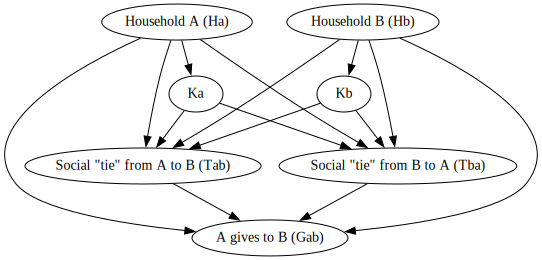

In [497]:
g.edge('Household A (Ha)','Ka') #Block membership
g.edge('Household B (Hb)','Kb') #Block membership
g.edge('Ka','Social "tie" from B to A (Tba)')
g.edge('Ka','Social "tie" from A to B (Tab)')
g.edge('Kb','Social "tie" from B to A (Tba)')
g.edge('Kb','Social "tie" from A to B (Tab)')
g

The networks derived from these models are very sparse compared to the Raw data.

## Varying effects as technology

Social networks try to express regularities of observations

Inferred social network is regularzied, a structured varying effect

Analogous problems: phylogeny, space, heritability, knowledge, personality

What happens when the clusters are not discrete but continuous? Age, distance, time, similarity 

would like to do local partial pooling. 

## Constructed Variables are Bad

Folk tradition of building outcome variables as a back-alley form of "control": ratios, differences, transformations

Body Mass Index (BMI) = mass/height^2

rates/ratios: per capita, per unit time

differences change scores, difference from reference

All of these are usually bad

## Per Capitated

Example: Dividing GDP by population does not stratify by population size. 

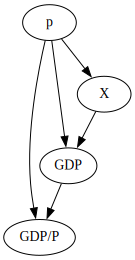

In [502]:
pc = graphviz.Digraph('pc')

pc.edge('p','GDP/P')
pc.edge('GDP','GDP/P')
pc.edge('p','GDP') # influence does not have to be linear!
pc.edge('p','X') #X is the cause the authors wanted. 
pc.edge('X','GDP')
pc

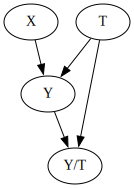

In [505]:
yt = graphviz.Digraph('yt')
yt.edge('T','Y') #T is observation time
yt.edge('T','Y/T') # Y/T transfers per unit time
yt.edge('Y','Y/T') #Y number of observed transfers
yt.edge('X','Y') # Cause of interest 
yt

#The proper way to correct for observation time (T) is to use an exposure

#One of the big problems is that we are trying to estimate rates, need to
#model it. 

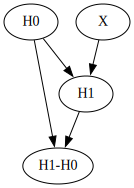

In [507]:
cs = graphviz.Digraph('cs')
cs.edge('H0','H1-H0')
cs.edge('H0','H1')
cs.edge('X','H1')
cs.edge('H1','H1-H0')
cs

# Baseline height (H0) is a powerful competing cause in H1
# Comparing H1-H0 is almost always a bad idea
# Assumes a linear relationship in growth/change
# Can't be true if there are floor/ceiling effects. 
# Change score makes very strong hiddden assumptions. 

## Constructed Variables Are Bad

Arithmetic is not stratification

Assumes a fixed relationship, when you should estimate

Ignores uncertainty, e.g. rates

Simimlar: Do not use model predicitons (residuals) as data

Do: Use causal logic, justify, test. 

## Adhockery

Long tradition of adhockery: ad hoc procedures, intuition as justification

"we expect a correlation" - very weird, loaded phrase. Why do you expect a correlation?

ad hoc procedures not justified by probability theory go wrong

Simple rule: Model what you measure. Don't invent new things